In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [42]:
# Load data
df = pd.read_csv("clean_data/cleaned_data_for_pca.csv")

# Remove time (keep only date)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'] = df['timestamp'].dt.tz_localize(None)
df['timestamp'] = df['timestamp'].dt.date

# Drop columns: open, high, low, close, volume, marketCap, circulatingSupply
df = df.drop(df.columns[1:8], axis = 1)
df.head()

,timestamp,percent_change_24h,percent_change_7d,percent_change_30d,volume_percent_change_24h,volume_percent_change_7d,volume_percent_change_30d,market_cap_percent_change_24h,market_cap_percent_change_7d,market_cap_percent_change_30d,...,realized_daily_volatility,peg_error,abs_peg_error,price_deviation_5d,price_deviation_30d,downward_price_deviation_5d,downward_price_deviation_30d,value,value_classification,fed_funds_rate
0,2022-01-27,-0.383843,-0.770964,-0.574027,80.926274,337.911988,530.354555,-0.000846,-0.030067,-0.108702,...,0.007869,-0.003514,0.003514,0.001598,0.001794,0.001572,0.001355,20,Extreme Fear,0.08
1,2022-01-28,-0.134154,-0.457796,-0.626531,208.043003,277.795437,1619.070786,-0.000195,-0.026060,-0.106611,...,0.008439,-0.004851,0.004851,0.002695,0.001984,0.002679,0.001619,24,Extreme Fear,0.08
2,2022-01-29,0.527108,0.227126,-0.158662,-73.108369,-11.967560,558.575201,-0.004606,-0.025761,-0.107427,...,0.002971,0.000395,0.000395,0.002694,0.001952,0.002679,0.001619,24,Extreme Fear,0.08
3,2022-01-30,-0.060697,-0.025268,-0.165009,-58.978769,-12.339415,120.223668,0.000130,-0.015048,-0.105380,...,0.005119,-0.000213,0.000213,0.002690,0.001934,0.002680,0.001619,29,Fear,0.08
4,2022-01-31,-0.175691,-0.239455,-0.272398,11.443363,-52.647649,162.998405,0.001352,-0.006924,-0.104382,...,0.004293,-0.001969,0.001969,0.002827,0.001963,0.002821,0.001659,20,Extreme Fear,0.08


### Define windows

In [63]:
event_date = pd.Timestamp("2022-05-09")
pre_event_start = pd.Timestamp("2022-05-02")
pre_event_end = pd.Timestamp("2022-05-08")

# Get data from start up till before event 
df['timestamp'] = pd.to_datetime(df['timestamp'])
data_before_event = df[df['timestamp'] <= pre_event_end].copy()
data_before_event.head()

,timestamp,percent_change_24h,percent_change_7d,percent_change_30d,volume_percent_change_24h,volume_percent_change_7d,volume_percent_change_30d,market_cap_percent_change_24h,market_cap_percent_change_7d,market_cap_percent_change_30d,...,realized_daily_volatility,peg_error,abs_peg_error,price_deviation_5d,price_deviation_30d,downward_price_deviation_5d,downward_price_deviation_30d,value,value_classification,fed_funds_rate
0,2022-01-27,-0.383843,-0.770964,-0.574027,80.926274,337.911988,530.354555,-0.000846,-0.030067,-0.108702,...,0.007869,-0.003514,0.003514,0.001598,0.001794,0.001572,0.001355,20,Extreme Fear,0.08
1,2022-01-28,-0.134154,-0.457796,-0.626531,208.043003,277.795437,1619.070786,-0.000195,-0.026060,-0.106611,...,0.008439,-0.004851,0.004851,0.002695,0.001984,0.002679,0.001619,24,Extreme Fear,0.08
2,2022-01-29,0.527108,0.227126,-0.158662,-73.108369,-11.967560,558.575201,-0.004606,-0.025761,-0.107427,...,0.002971,0.000395,0.000395,0.002694,0.001952,0.002679,0.001619,24,Extreme Fear,0.08
3,2022-01-30,-0.060697,-0.025268,-0.165009,-58.978769,-12.339415,120.223668,0.000130,-0.015048,-0.105380,...,0.005119,-0.000213,0.000213,0.002690,0.001934,0.002680,0.001619,29,Fear,0.08
4,2022-01-31,-0.175691,-0.239455,-0.272398,11.443363,-52.647649,162.998405,0.001352,-0.006924,-0.104382,...,0.004293,-0.001969,0.001969,0.002827,0.001963,0.002821,0.001659,20,Extreme Fear,0.08


In [64]:
# Select numeric columns only
numeric_cols = data_before_event.select_dtypes(include='number').columns
X_numeric = data_before_event[numeric_cols]

# Scale data for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)


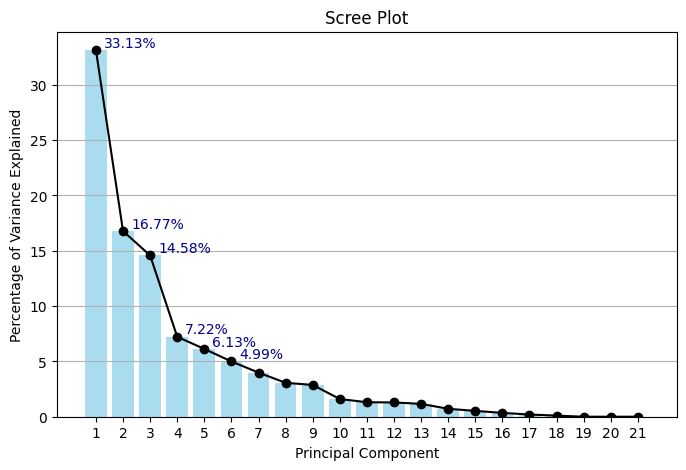

In [65]:
# Run PCA
pca = PCA()
pca.fit(X_scaled)

# Variance explained per PC (in %)
explained_variance_percent = pca.explained_variance_ratio_ * 100

# Plotting a Scree plot
plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_variance_percent)+1), explained_variance_percent, alpha=0.7, color='skyblue')
plt.plot(range(1, len(explained_variance_percent)+1), explained_variance_percent, marker='o', color='black')  
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')
plt.title('Scree Plot')
plt.xticks(range(1, len(explained_variance_percent)+1))  
plt.grid(axis='y')

# Annotate top 6 points
for i in range(6):
    plt.text(
        i+1.3, 
        explained_variance_percent[i], 
        f"{explained_variance_percent[i]:.2f}%", 
        ha='left', 
        va='bottom', 
        fontsize=10, 
        color='darkblue'
    )

plt.show()

In [89]:
for i in range(1, 11):
    pc_name = f"PC{i}"
    print(f"\n===== {pc_name} =====")
    # Get top 10 features by absolute value, but show actual values
    top_features = (
        loadings.loc[pc_name]
        .abs()
        .sort_values(ascending=False)
        .head(5)
        .index
    )
    print(loadings.loc[pc_name, top_features])


===== PC1 =====
market_cap_percent_change_7d             0.349720
circulating_supply_percent_change_7d     0.341109
market_cap_percent_change_24h            0.323854
circulating_supply_percent_change_24h    0.319302
peg_error                               -0.307305
Name: PC1, dtype: float64

===== PC2 =====
circulating_supply_percent_change_30d    0.395723
market_cap_percent_change_30d            0.381501
downward_price_deviation_30d             0.343134
percent_change_7d                        0.335191
percent_change_30d                       0.329616
Name: PC2, dtype: float64

===== PC3 =====
volume_percent_change_30d      0.464036
volume_percent_change_7d       0.410216
downward_price_deviation_5d    0.311495
realized_daily_volatility      0.309320
volume_percent_change_24h      0.305948
Name: PC3, dtype: float64

===== PC4 =====
price_deviation_30d             0.426093
downward_price_deviation_5d     0.366000
fed_funds_rate                 -0.351158
value                          

In [66]:
# Determine k (number of PCs explaining >= 80% of variance)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
k = np.argmax(cumulative_variance >= 0.80) + 1
print("Number of PCs explaining ≥80% variance:", k)


Number of PCs explaining ≥80% variance: 6


### PCA with an expanding window 

In [67]:
min_window = 30  
pc_scores_list = []

for i in range(min_window-1, len(X_numeric)):
    # Expanding window: all data from start to current day
    window_data = X_numeric.iloc[:i+1]
    
    # Standardize data 
    scaler_window = StandardScaler()
    X_scaled = scaler_window.fit_transform(window_data)
    
    # PCA with fixed 6 PCs
    pca_window = PCA(n_components=k)
    pca_window.fit(X_scaled)
    
    # Get PC scores for the last day only
    last_day_score = pca_window.transform(X_scaled)[-1]
    pc_scores_list.append(last_day_score)

# Convert to DataFrame
timestamps_pre_event = data_before_event['timestamp']
pc_scores_df = pd.DataFrame(pc_scores_list, columns=[f'PC{i+1}' for i in range(k)])
pc_scores_df['timestamp'] = timestamps_pre_event.iloc[min_window-1:].values



/Users/judy/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/judy/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/judy/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/judy/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/judy/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/judy/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base

### Time-indexed Plots


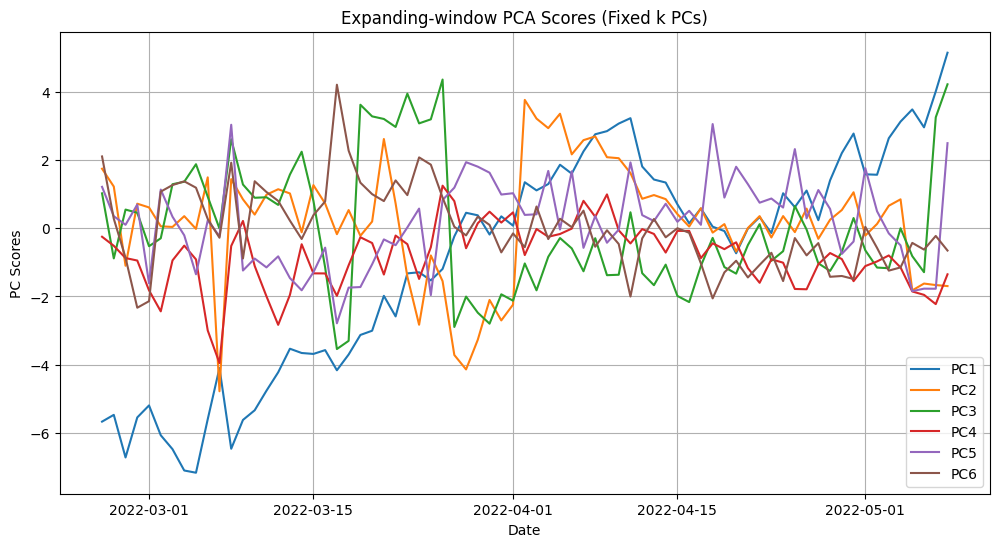

In [68]:
# Line Plot
# Plot PC scores over time
plt.figure(figsize=(12,6))
for i in range(k):
    plt.plot(pc_scores_df['timestamp'], pc_scores_df[f'PC{i+1}'], label=f'PC{i+1}')
plt.xlabel('Date')
plt.ylabel('PC Scores')
plt.title('Expanding-window PCA Scores (Fixed k PCs)')
plt.legend()
plt.grid(True)
plt.show()

PC1: exhibits a clear upward drift entering the pre-event window, suggesting increasing systemic pressure prior to the TerraUSD collapse.  
PC2:       
PC3: shows a large spike immediately prior to the collapse, indicating potential instability emerging in secondary factors.  
PC4:  
PC5:  
PC6: relatively stable, limited relevance for early warning.  

# K=10, 95%

In [73]:
k = 10
min_window = 30  
pc_scores_list = []

# Expanding window PCA with fixed k PCs
for i in range(min_window-1, len(X_numeric)):
    # Expanding window: all data from start to current day
    window_data = X_numeric.iloc[:i+1]
    
    # Standardize data 
    scaler_window = StandardScaler()
    X_scaled = scaler_window.fit_transform(window_data)
    
    # PCA with fixed 6 PCs
    pca_window = PCA(n_components=k)
    pca_window.fit(X_scaled)
    
    # Get PC scores for the last day only
    last_day_score = pca_window.transform(X_scaled)[-1]
    pc_scores_list.append(last_day_score)

# Convert to DataFrame
timestamps_pre_event = data_before_event['timestamp']
pc_scores_df = pd.DataFrame(pc_scores_list, columns=[f'PC{i+1}' for i in range(k)])
pc_scores_df['timestamp'] = timestamps_pre_event.iloc[min_window-1:].values


/Users/judy/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/judy/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/judy/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/judy/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/judy/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/judy/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base

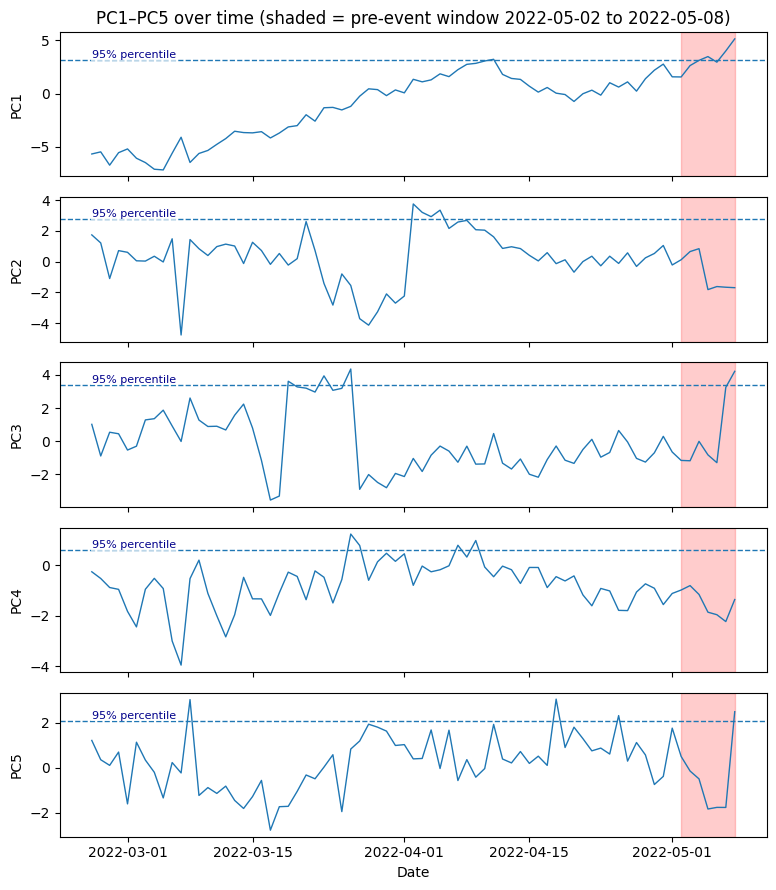

In [75]:
# Plot
# 95th percentile line (per PC)
p95 = pc_scores_df.quantile(0.95)

pc_cols = [f"PC{i}" for i in range(1, 6)]
# Plot PC1..PC10 with shaded pre-event window
fig, axes = plt.subplots(5, 1, figsize=(8, 9), sharex=True)

for i, col in enumerate(pc_cols):
    ax = axes[i]
    ax.plot(pc_scores_df['timestamp'], pc_scores_df[col], linewidth=1)
    ax.axvspan(pre_event_start, pre_event_end, alpha=0.2, color = 'red')  # shaded pre-event window
    ax.axhline(p95[col], linestyle="--", linewidth=1, label='95th percentile') # 95% line
    ax.text(
        pc_scores_df['timestamp'].iloc[0],  # leftmost x
        p95[col],                           # y position
        "95% percentile",
        va='bottom', ha='left',
        fontsize=8, color='darkblue',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5)
    )
    ax.set_ylabel(col)
    # ax.axhline(0, linewidth=0.8, linestyle="--")
    ax.set_ylabel(col)

axes[0].set_title("PC1–PC5 over time (shaded = pre-event window 2022-05-02 to 2022-05-08)")
axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

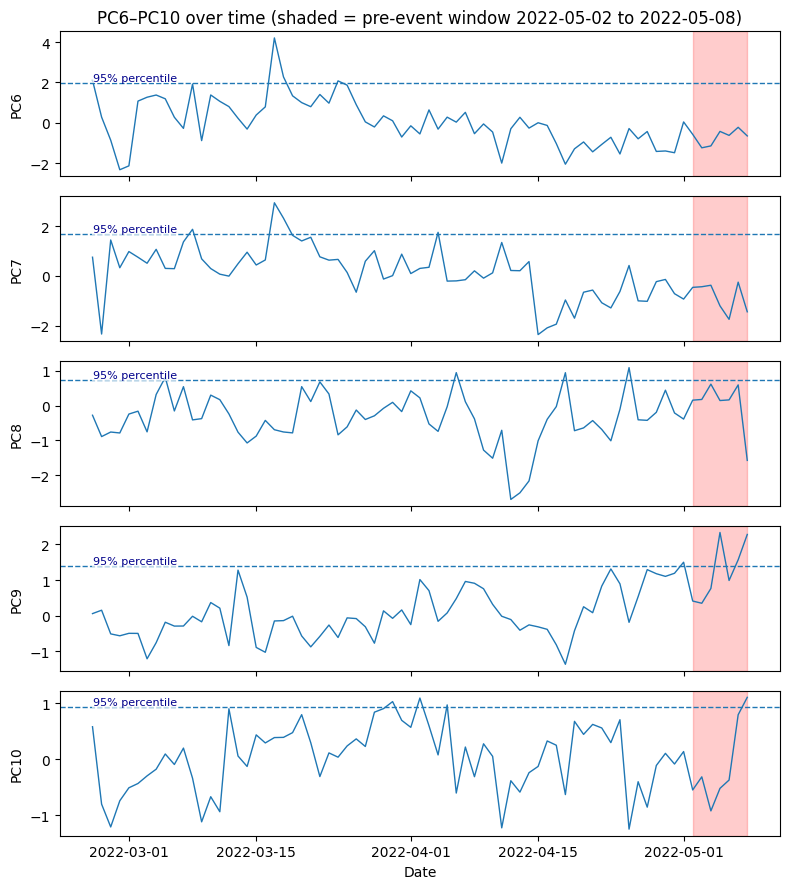

In [76]:
# Plot
# 95th percentile line (per PC)
p95 = pc_scores_df.quantile(0.95)

pc_cols = [f"PC{i}" for i in range(6, 11)]
# Plot PC1..PC10 with shaded pre-event window
fig, axes = plt.subplots(5, 1, figsize=(8, 9), sharex=True)

for i, col in enumerate(pc_cols):
    ax = axes[i]
    ax.plot(pc_scores_df['timestamp'], pc_scores_df[col], linewidth=1)
    ax.axvspan(pre_event_start, pre_event_end, alpha=0.2, color = 'red')  # shaded pre-event window
    ax.axhline(p95[col], linestyle="--", linewidth=1, label='95th percentile') # 95% line
    ax.text(
        pc_scores_df['timestamp'].iloc[0],  # leftmost x
        p95[col],                           # y position
        "95% percentile",
        va='bottom', ha='left',
        fontsize=8, color='darkblue',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5)
    )
    ax.set_ylabel(col)
    # ax.axhline(0, linewidth=0.8, linestyle="--")
    ax.set_ylabel(col)

axes[0].set_title("PC6–PC10 over time (shaded = pre-event window 2022-05-02 to 2022-05-08)")
axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

# Symmetric z-score bands

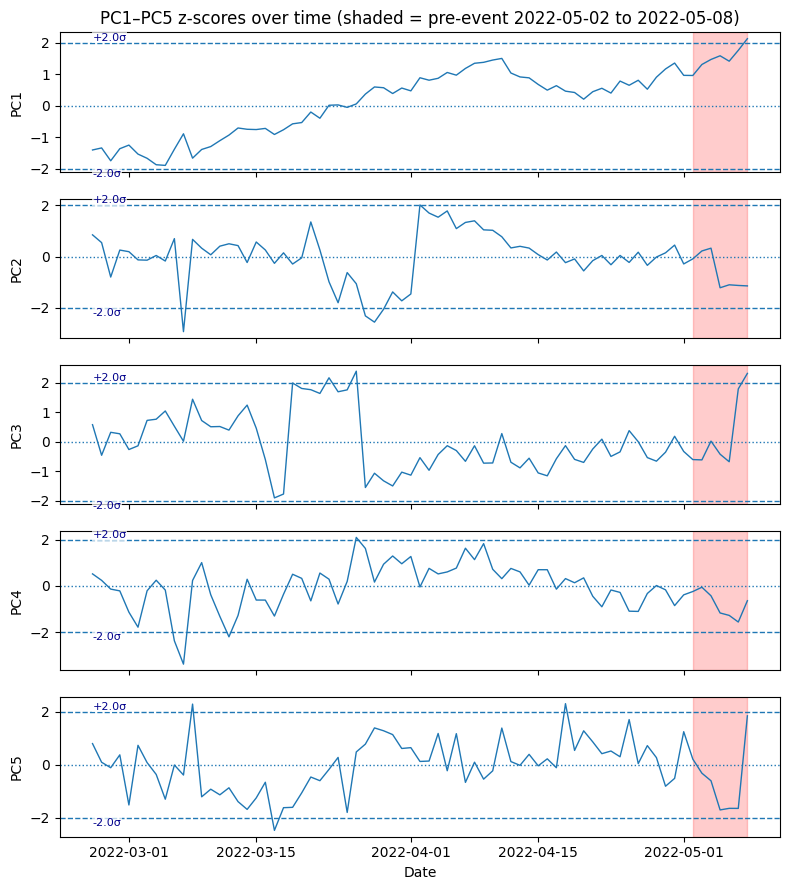

In [95]:
pc_cols = [f"PC{i}" for i in range(1, 6)]
m = 2.0  # symmetric band level: ±m


# FIXED baseline (best for event study): use "normal" period before pre-event
baseline_end = pre_event_start - pd.Timedelta(days=1)
baseline_mask = pc_scores_df["timestamp"] <= baseline_end

# Compute z-scores per PC using fixed baseline mean/std
z_df = pc_scores_df[["timestamp"]].copy()
for col in pc_cols:
    base = pc_scores_df.loc[baseline_mask, col].dropna()
    mu = base.mean()
    sd = base.std(ddof=1)
    z_df[col] = (pc_scores_df[col] - mu) / sd

# ----------------------------
# Plot PC1..PC5 Z-scores with ±m bands
# ----------------------------
fig, axes = plt.subplots(5, 1, figsize=(8, 9), sharex=True)

for i, col in enumerate(pc_cols):
    ax = axes[i]
    ax.plot(z_df["timestamp"], z_df[col], linewidth=1)

    # shaded pre-event window
    ax.axvspan(pre_event_start, pre_event_end, alpha=0.2, color="red")

    # symmetric bands
    ax.axhline(+m, linestyle="--", linewidth=1)
    ax.axhline(-m, linestyle="--", linewidth=1)
    ax.axhline(0, linestyle=":", linewidth=1)

    # labels on the left
    x0 = z_df["timestamp"].iloc[0]
    ax.text(x0, +m, f"+{m}σ", va="bottom", ha="left",
            fontsize=8, color="darkblue",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.5))
    ax.text(x0, -m, f"-{m}σ", va="top", ha="left",
            fontsize=8, color="darkblue",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.5))

    ax.set_ylabel(col)

axes[0].set_title(f"PC1–PC5 z-scores over time (shaded = pre-event {pre_event_start.date()} to {pre_event_end.date()})")
axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

In [96]:
import pandas as pd
import numpy as np

event_date = pd.to_datetime("2022-05-09")

def hit_summary(z_df, col, m, start=None, end=None, event_date=None):
    tmp = z_df[["timestamp", col]].dropna().copy()
    tmp["timestamp"] = pd.to_datetime(tmp["timestamp"])

    if start is not None:
        tmp = tmp[tmp["timestamp"] >= pd.to_datetime(start)]
    if end is not None:
        tmp = tmp[tmp["timestamp"] <= pd.to_datetime(end)]

    hits = tmp[col].abs() >= m

    # first hit date
    first_hit_date = tmp.loc[hits, "timestamp"].min() if hits.any() else None

    # lead time calculation
    if event_date is not None and first_hit_date is not None:
        lead_time = (event_date - first_hit_date).days
    else:
        lead_time = np.nan

    return {
        "PC": col,
        "n_days": int(len(tmp)),
        "hit_days(|z|>=m)": int(hits.sum()),
        "hit_rate": float(hits.mean()) if len(tmp) else np.nan,
        "max_abs_z": float(tmp[col].abs().max()) if len(tmp) else np.nan,
        "first_hit_date": first_hit_date,
        "lead_time_days": lead_time
    }

# Pre-event window summary
summary_pre = [
    hit_summary(z_df, c, m, pre_event_start, pre_event_end, event_date)
    for c in pc_cols
]

# Full sample summary (lead time relative to event)
summary_all = [
    hit_summary(z_df, c, m, event_date=event_date)
    for c in pc_cols
]

print("Pre-event window summary:")
print(pd.DataFrame(summary_pre).sort_values("max_abs_z", ascending=False))

print("\nFull sample summary:")
print(pd.DataFrame(summary_all).sort_values("lead_time_days", ascending=False))

Pre-event window summary:
    PC  n_days  hit_days(|z|>=m)  hit_rate  max_abs_z first_hit_date  \
2  PC3       7                 1  0.142857   2.312032     2022-05-08   
0  PC1       7                 1  0.142857   2.131592     2022-05-08   
4  PC5       7                 0  0.000000   1.840477            NaT   
3  PC4       7                 0  0.000000   1.563491            NaT   
1  PC2       7                 0  0.000000   1.218081            NaT   

   lead_time_days  
2             1.0  
0             1.0  
4             NaN  
3             NaN  
1             NaN  

Full sample summary:
    PC  n_days  hit_days(|z|>=m)  hit_rate  max_abs_z first_hit_date  \
3  PC4      73                 4  0.054795   3.390719     2022-03-06   
1  PC2      73                 5  0.068493   2.930461     2022-03-07   
4  PC5      73                 3  0.041096   2.476655     2022-03-08   
2  PC3      73                 3  0.041096   2.387390     2022-03-23   
0  PC1      73                 1  0.013

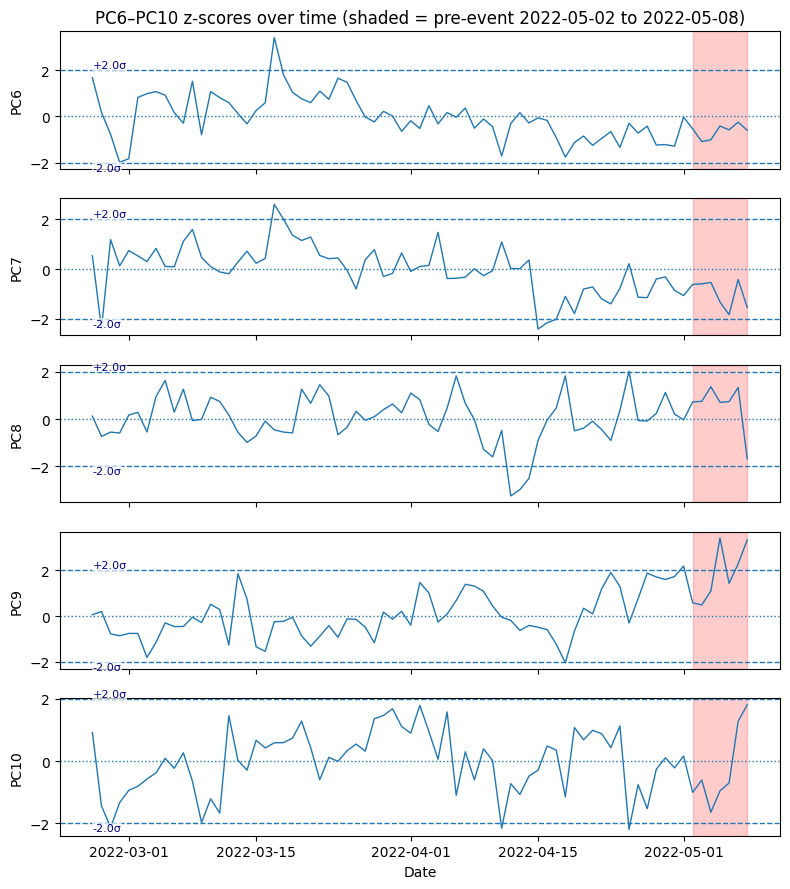

In [94]:
pc_cols = [f"PC{i}" for i in range(6, 11)]
m = 2.0  # symmetric band level: ±m


# FIXED baseline (best for event study): use "normal" period before pre-event
baseline_end = pre_event_start - pd.Timedelta(days=1)
baseline_mask = pc_scores_df["timestamp"] <= baseline_end

# Compute z-scores per PC using fixed baseline mean/std
z_df = pc_scores_df[["timestamp"]].copy()
for col in pc_cols:
    base = pc_scores_df.loc[baseline_mask, col].dropna()
    mu = base.mean()
    sd = base.std(ddof=1)
    z_df[col] = (pc_scores_df[col] - mu) / sd

# ----------------------------
# Plot PC1..PC5 Z-scores with ±m bands
# ----------------------------
fig, axes = plt.subplots(5, 1, figsize=(8, 9), sharex=True)

for i, col in enumerate(pc_cols):
    ax = axes[i]
    ax.plot(z_df["timestamp"], z_df[col], linewidth=1)

    # shaded pre-event window
    ax.axvspan(pre_event_start, pre_event_end, alpha=0.2, color="red")

    # symmetric bands
    ax.axhline(+m, linestyle="--", linewidth=1)
    ax.axhline(-m, linestyle="--", linewidth=1)
    ax.axhline(0, linestyle=":", linewidth=1)

    # labels on the left
    x0 = z_df["timestamp"].iloc[0]
    ax.text(x0, +m, f"+{m}σ", va="bottom", ha="left",
            fontsize=8, color="darkblue",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.5))
    ax.text(x0, -m, f"-{m}σ", va="top", ha="left",
            fontsize=8, color="darkblue",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.5))

    ax.set_ylabel(col)

axes[0].set_title(f"PC6–PC10 z-scores over time (shaded = pre-event {pre_event_start.date()} to {pre_event_end.date()})")
axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

In [93]:
import pandas as pd
import numpy as np

event_date = pd.to_datetime("2022-05-09")

def hit_summary(z_df, col, m, start=None, end=None, event_date=None):
    tmp = z_df[["timestamp", col]].dropna().copy()
    tmp["timestamp"] = pd.to_datetime(tmp["timestamp"])

    if start is not None:
        tmp = tmp[tmp["timestamp"] >= pd.to_datetime(start)]
    if end is not None:
        tmp = tmp[tmp["timestamp"] <= pd.to_datetime(end)]

    hits = tmp[col].abs() >= m

    # first hit date
    first_hit_date = tmp.loc[hits, "timestamp"].min() if hits.any() else None

    # lead time calculation
    if event_date is not None and first_hit_date is not None:
        lead_time = (event_date - first_hit_date).days
    else:
        lead_time = np.nan

    return {
        "PC": col,
        "n_days": int(len(tmp)),
        "hit_days(|z|>=m)": int(hits.sum()),
        "hit_rate": float(hits.mean()) if len(tmp) else np.nan,
        "max_abs_z": float(tmp[col].abs().max()) if len(tmp) else np.nan,
        "first_hit_date": first_hit_date,
        "lead_time_days": lead_time
    }

# Pre-event window summary
summary_pre = [
    hit_summary(z_df, c, m, pre_event_start, pre_event_end, event_date)
    for c in pc_cols
]

# Full sample summary (lead time relative to event)
summary_all = [
    hit_summary(z_df, c, m, event_date=event_date)
    for c in pc_cols
]

print("Pre-event window summary:")
print(pd.DataFrame(summary_pre).sort_values("max_abs_z", ascending=False))

print("\nFull sample summary:")
print(pd.DataFrame(summary_all).sort_values("lead_time_days", ascending=False))

Pre-event window summary:
     PC  n_days  hit_days(|z|>=m)  hit_rate  max_abs_z first_hit_date  \
3   PC9       7                 3  0.428571   3.427237     2022-05-05   
1   PC7       7                 0  0.000000   1.826559            NaT   
4  PC10       7                 0  0.000000   1.810551            NaT   
2   PC8       7                 0  0.000000   1.683826            NaT   
0   PC6       7                 0  0.000000   1.082937            NaT   

   lead_time_days  
3             4.0  
1             NaN  
4             NaN  
2             NaN  
0             NaN  

Full sample summary:
     PC  n_days  hit_days(|z|>=m)  hit_rate  max_abs_z first_hit_date  \
1   PC7      73                 6  0.082192   2.604171     2022-02-26   
4  PC10      73                 3  0.041096   2.194354     2022-02-27   
0   PC6      73                 1  0.013699   3.407575     2022-03-17   
2   PC8      73                 4  0.054795   3.244567     2022-04-12   
3   PC9      73             

# Biplot

In [83]:
from adjustText import adjust_text

def biplot(scores, loadings, feature_names, explained_variance, 
           pc_x=1, pc_y=2, scale_scores=1, scale_loadings=1):
    
    x_idx = pc_x - 1
    y_idx = pc_y - 1
    
    plt.figure(figsize=(10,8))
    
    # Plot scores
    plt.scatter(scores[:, x_idx] * scale_scores, 
                scores[:, y_idx] * scale_scores,
                alpha=0.5, color='steelblue', label='Observations')
    
    texts = []
    
    # Plot loadings
    for i, feature in enumerate(feature_names):
        x = loadings[i, x_idx] * scale_loadings
        y = loadings[i, y_idx] * scale_loadings
        
        plt.arrow(0, 0, x, y,
                  color='red', alpha=0.7, head_width=0.05)
        
        texts.append(
            plt.text(x, y, feature,
                     fontsize=9, color='black')
        )
    
    # Automatically adjust text positions
    adjust_text(texts, 
                arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))
    
    plt.xlabel(f'PC{pc_x} ({explained_variance[x_idx]:.1f}% variance)')
    plt.ylabel(f'PC{pc_y} ({explained_variance[y_idx]:.1f}% variance)')
    plt.title(f'PCA Biplot: PC{pc_x} vs PC{pc_y}')
    plt.grid(True)
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.7)
    plt.show()

/Users/judy/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/judy/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/judy/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


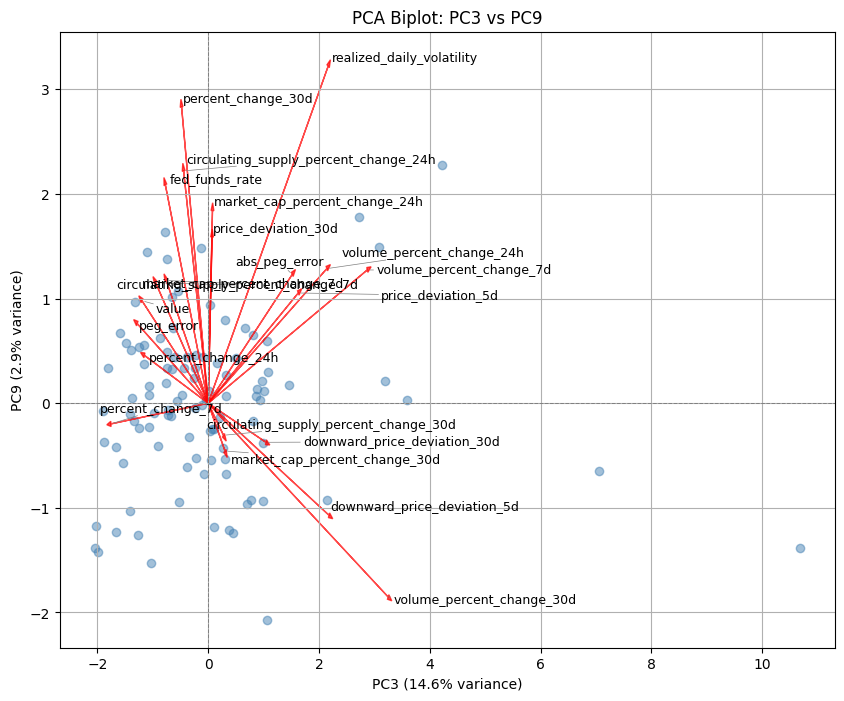

In [84]:
# PC3 vs PC9
numeric_cols_list = numeric_cols.tolist()
biplot(scores=pca.transform(X_scaled), 
       loadings=pca.components_.T, 
       feature_names=numeric_cols_list, 
       explained_variance=explained_variance_percent, 
       pc_x=3, pc_y=9, 
       scale_scores=1, scale_loadings=7)
